In [7]:
import numpy as np
import matplotlib.pyplot as plt
from findiff import FinDiff
from scipy.sparse.linalg import inv
from scipy.sparse import eye, diags
import matplotlib.animation as animation

plt.rcParams["axes.labelsize"] = 16

# Notebook 5: Solving Schrödinger's Equation in Python

In this notebook, we will see how to solve Schrödinger's equation in 1D for a single particle in a potential well. The method we use here is not the fastest or the most accurate and the software will be written in a rough format. Your task next week will be to develop a python package which implements this approach following good software practise! But for now, please read through this worksheet to make sure you understand how we obtain the approximate solution.

## Quantum Mechanics Reminder

Recall that the one-dimensional time-dependent Schrödinger equation for a particle of mass $m$ in a potential $V(x, t)$ can be written as

\begin{align}
i \frac{\partial \Psi(x, t)}{\partial t} = H \psi(x,t)\,
\end{align}

where $\Psi(x, t)$ is the complex wave function as a function of time $t$ and space $x$ and $H$ is the Hamiltonian operator

\begin{align}
H = -\frac{1}{2} \frac{\partial^{2}}{\partial x^2} + V(x, t)\,.
\end{align}

For simplicity, we have set $m=1$ and $\hbar=1$.

You will no doubt have seen analytic solutions to this, and maybe even numerical solutions as well. In this worksheet, we will solve it for a time invariant potential $V(x, t) = V(x) = k x^2$ where $k$ is an arbitrary constant. (Note: this is known as a Quantum Harmonic Oscillator and also has a known analytic solution, but here we use it as an example to demonstrate how to solve the problem numerically). We also need the initial conditions, in this case, we'll state that 

\begin{align}
\Psi(t=0) = e^{-(x + 2)^{2}}\,.
\end{align}

Let's plot this initial state and the potential. Because they are both arbitrarily scaled, we put them on two separate axes

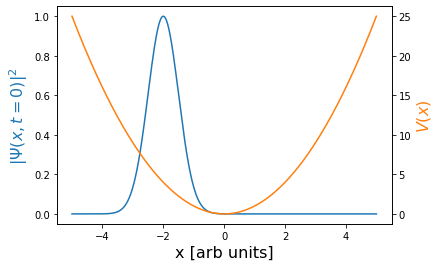

In [8]:
x_array = np.linspace(-5, 5, 500)

k = 1 
v_x = k * x_array ** 2
psi = np.exp(-(x_array+2)**2)

fig, ax = plt.subplots()

ax.plot(x_array, np.abs(psi)**2)
ax.set_xlabel("x [arb units]")
ax.set_ylabel("$|\Psi(x, t=0)|^2$", color="C0")

ax_twin = ax.twinx()
ax_twin.plot(x_array, v_x, color='C1')
ax_twin.set_ylabel("$V(x)$", color="C1")
plt.show()

To evolve this system in time, we will develop a finite difference scheme. But, before we get to that let's quickly have a reminder on finite difference operators!

## Recap on finite difference operators

Recall that the second-order central finite difference method yields
\begin{align}
y'' = \frac{\partial^{2} f(x)}{\partial x^2} \approx \frac{f(x-h) -2 f(x) + f(x + h)}{h^2}
\end{align}
where $\frac{\partial^{2}}{\partial x^2}$ is the operator.

As a concrete example, consider $f(x) = \sin(x)$. Clearly, $y'' = -\cos(x)$, but let's demonstrate how we can use finite differencing to perform this calculation numerically.

### Method 1: using a `for` loop

One easy way to apply the finice difference operator is to simply apply the equation above over a grid of values. Let's have a go and check that it works

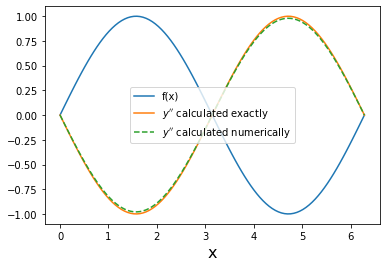

In [15]:
def f(x):
    """ The function we want to calculate the finite difference for"""
    return np.sin(x)

# Define a grid in x
N = 100
x_array = np.linspace(0, 2 * np.pi, N)

# Loop over the grid and calculate the second order derivative at each point
ypp_method1 = []
h = 0.5
for x in x_array:
    second_order_derivative = (f(x - h) - 2 * f(x) + f(x + h)) / h ** 2
    ypp_method1.append(second_order_derivative)
   
# Plot the results
fig, ax = plt.subplots()
ax.plot(x_array, f(x_array), label="f(x)")
ax.plot(x_array, -np.sin(x_array), label="$y''$ calculated exactly")
ax.plot(x_array, ypp_method1, "--", label="$y''$ calculated numerically")
ax.set(xlabel="x")
ax.legend()
plt.show()

<div class="alert alert-block alert-danger">
<b>Challenge 5.1:</b> Investigate how changing the value of h in the script impacts the quality of the solution. You may wish to rewrite it as a function and plot the residual rather than the value.
</div>

This works nicely - we get almost the same solution numerically as we do exactly. But, there is a lot of calculation going on in a linear fashion! For each for loop, we perform 3 evaluations of the function, so there is a total of $100 \times 3=300$ operations, all performed in sequence. We are not taking advantage of parallelisation. Moreover, if we make $h$ equal to the size of the grid, we can reuse calculations. I.e, we should only do 100 calculations in parallel. To do this, we can rewrite the problem in matrix form.

### Method 2: Represent the operator as a matrix

Let us refer to $x_i \forall i \in [0, N-1]$ as the $N$-length grid of points that we want to evaluate $f''(x)$. And, let us set $h=x_{i+1}-x{i}$. Then, writing $f_i = f(x_i)$, we can write each individual term as
\begin{align}
y''_i = \frac{f_{i-1} - 2 f_{i} + f_{i+1}}{h^2}
\end{align}

Now, let's say we have a grid of size $N=8$ (this is big enough to show the problem, but much too small in practise of course!). Then, we can write this out the components of $y''_i$ as a matrix equation:

\begin{align}
\left[\begin{array}{c}y_0 \\ y_1 \\ y_2\\ y_3\\ y_4 \\ y_5 \\ y_6  \\ y_7\end{array}\right] = 
\frac{1}{h^2}
\left[\begin{array}{ccccc}
?? & ?? & ?? & ?? & 0 & 0 & 0 & 0\\ 
1 & -2 & 1 & 0 & 0 & 0 & 0 & 0\\ 
0 & 1 & -2 & 1 & 0 & 0 & 0 & 0\\ 
0 & 0 & 1 & -2 & 1 & 0 & 0 & 0\\ 
0 & 0 & 0 & 1 & -2 & 1 & 0 & 0\\ 
0 & 0 & 0 & 0 & 1 & -2 & 1 & 0\\ 
0 & 0 & 0 & 0 & 0 & 1 & -2 & 1\\ 
0 & 0 & 0 & 0 & ?? & ?? & ?? & ??\\ 
\end{array}\right]
\left[\begin{array}{c}f_0 \\ f_1 \\ f_2 \\ f_3\\ f_4\\ f_5\\ f_6 \\ f_7 \end{array}\right]
\end{align}
If you look at the middle rows, e.g. row 3, you'll see you can read off the coefficients from the equation above.
But, you may notice that the first and last row's do not correspond to the central finite difference equation. This is because at the boundary, that equation cannot be applied! Instead, we use forward/backward differencing, which results in different coefficients. Luckily, we don't need to implement these sort of problems from scratch, there is a nice package called `findiff` which will do it for us. Let's use it to print out the Matrix above (note we set `h=1` because the matrix it prints includes that scaling:

In [17]:
h = 1
N = 8
order = 2
d2_dx2 = FinDiff(0, h, order)
d2_dx2.matrix((N,)).toarray()

array([[ 2., -5.,  4., -1.,  0.,  0.,  0.,  0.],
       [ 1., -2.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -2.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -2.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -2.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -2.,  1.],
       [ 0.,  0.,  0.,  0., -1.,  4., -5.,  2.]])

Okay, now let's use `FinDiff` to perform the finite differencing

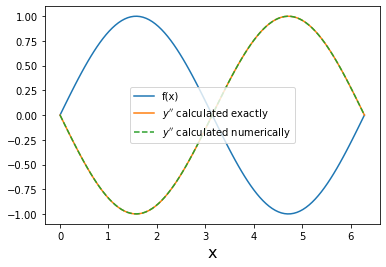

In [18]:
N = 100
x_array = np.linspace(0, 2 * np.pi, N)

h = x_array[1] - x_array[0]
fx_array = f(x_array)
ypp_method2 = FinDiff(0, h, 2).matrix((N,)) * fx_array

# Plot the results
fig, ax = plt.subplots()
ax.plot(x_array, f(x_array), label="f(x)")
ax.plot(x_array, -np.sin(x_array), label="$y''$ calculated exactly")
ax.plot(x_array, ypp_method2, "--", label="$y''$ calculated numerically")
ax.set(xlabel="x")
ax.legend()
plt.show()

<div class="alert alert-block alert-danger">
<b>Challenge 5.2:</b> Look up the documentation for findiff (Hint: Google) and provide a sentence or two explaining what the three arguments used above are.
</div>

## Numerical Solutions to the Time-Dependent Schrödinger Equation

Okay, now we get into the details of the method to solve the time-dependent Schrödinger equation. We will use a technique known as the Crank-Nicholson algorithm. This proceeds as follows, first discretise it on a grid in time and use forward differncing to approximate the time derivative:

\begin{align}
i \frac{\partial \Psi(x, t)}{\partial t} \approx i \frac{\Psi^{n+1} - \Psi^{n}}{\Delta t} = H \Psi^n\,
\end{align}

where $\Psi^n$ is taken to mean the wave function at time $t_n$ evaluated at $x$ (which will be a grid of points). Next, rearrange to give

\begin{align}
\Psi^{n+1} = \Psi^n - i \Delta t H \Psi^n = (1 - i \Delta t H)\Psi^n
\end{align}

It may look like we are done: we can evolve the wavefunction explicitly using this forward differencing scheme! However, in practice solutions do not conserve the norm of $\Psi$. Instead, the Crank-Nicholson algorithm sets up the implicit scheme by applying backward differencing:

\begin{align}
i \frac{\partial \Psi(x, t)}{\partial t} \approx i \frac{\Psi^{n+1} - \Psi^{n}}{\Delta t} = H \Psi^{n+1} \Rightarrow \Psi^{n+1} = \Psi^{n} - i\Delta t H \Psi^{n+1}
\end{align}

Now we have two equations:

\begin{align}
\Psi^{n+1} &= (1 - i\Delta t H)\Psi^{n} \\
\Psi^{n+1} &= \Psi^{n} - i\Delta t H \Psi^{n+1}
\end{align}

The Crank-Nicholson algorithm averages these:
\begin{align}
\Psi^{n+1} = \frac{1}{2}\left(1 - i\Delta t H\right)\Psi^{n} + \frac{1}{2}\left(\Psi^{n} - i\Delta t H \Psi^{n+1}\right)
\end{align}

Then, rearranging we have

\begin{align}
\Psi^{n+1} = \underbrace{\left(1 + \frac{i \Delta t}{2}H\right)^{-1}\left(1 - \frac{i \Delta t}{2}H\right)}_{=U} \Psi^n
\end{align}

where the matrix 𝑈 thus defined is the discretized version of the time propagation operator in the Crank-Nicholson scheme.

This method is a second order algorithm in $t$, i.e. the discretization error decreases as $\tau^2$. The finite difference representation of the second derivative $d^2/dx^2$ is also good to second order in $h^2$. The Crank-Nicholson Algorithm also gives a unitary evolution in time. That is especially useful for quantum mechanics where unitarity assures that the normalization of the wavefunction is unchanged over time.

### Implementation

Okay, let's have a go at implementing the Crank-Nicholson solution, using our initial data defined above. The first step is to realise that in discretising in time,

\begin{align}
H = -\frac{1}{2} \frac{\partial^{2}}{\partial x^2} + V(x)\,,
\end{align}

is now represented by a matrix operator. We can implement this using `FinDiff` for the second-order spatial derivative. Meanwhile $V(x)$ is a diagonal matrix.

In [19]:
# Input parameters
Nx = 500
xmin = -5
xmax = 5

Nt = 250
tmin = 0
tmax = 20
k = 1 

# Calculate grid, potential, and initial wave function
x_array = np.linspace(xmin, xmax, Nx)
t_array = np.linspace(tmin, tmax, Nt)
v_x = k * x_array ** 2
psi = np.exp(-(x_array+2)**2)

# Calculate finite difference elements
dt = t_array[1] - t_array[0]
dx = x_array[1] - x_array[0]

# Convert to a diagonal matrix
v_x_matrix = diags(v_x)

# Calculate the Hamiltonian matrix
H = -0.5 * FinDiff(0, dx, 2).matrix(x_array.shape) + v_x_matrix

# Apply boundary conditions to the Hamiltonian
H[0, :] = H[-1, :] = 0
H[0, 0] = H[-1, -1] = 1

# Calculate U
I_plus = eye(Nx) + 1j * dt / 2. * H
I_minus = eye(Nx) - 1j * dt / 2. * H
U = inv(I_minus).dot(I_plus)

# Iterate over each time, appending each calculation of psi to a list
psi_list = []
for t in t_array:
    psi = U.dot(psi)
    psi[0] = psi[-1] = 0
    psi_list.append(np.abs(psi))

/home/rahmah/anaconda3/envs/gw2/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/rahmah/anaconda3/envs/gw2/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/rahmah/anaconda3/envs/gw2/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


### Visualisation
We now have a numerical solution stored in our list `psi_list`. Next step, visualize! Perhaps the easiest way to see things is to plot a 2D colormap

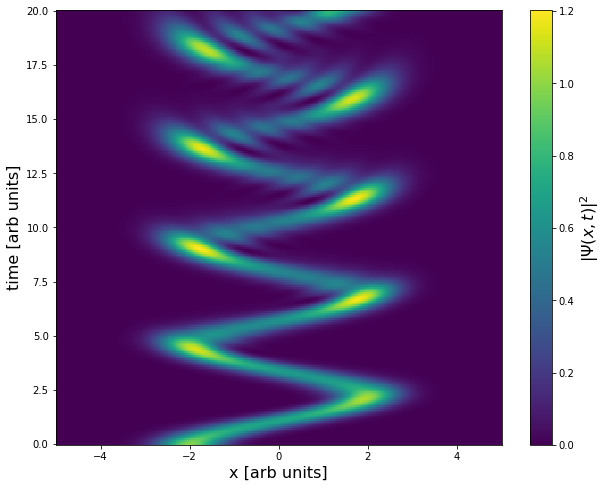

In [20]:
psi_mag_squared = np.abs(psi_list)**2

fig, ax = plt.subplots(figsize=(10, 8))
c = ax.pcolor(x_array, t_array, psi_mag_squared, shading="auto")
ax.set(xlabel="x [arb units]", ylabel="time [arb units]")
cbar = fig.colorbar(c, ax=ax)
cbar.set_label("$|\Psi(x, t)|^2$")
plt.show()

This shows time increase vertically. We can see the probability density sloshing back and forth... but what is happening at the end? 

An alternative way to view the data is with an animation. This code will create an mp4 file.

In [ ]:
fig, ax = plt.subplots()

ax.set_xlabel("x [arb units]")
ax.set_ylabel("$|\Psi(x, t)|$", color="C0")

ax_twin = ax.twinx()
ax_twin.plot(x_array, v_x, color="C1")
ax_twin.set_ylabel("V(x) [arb units]", color="C1")

line, = ax.plot([], [], color="C0", lw=2)
ax.grid()
xdata, ydata = [], []

def run(psi):
    line.set_data(x_array, np.abs(psi)**2)
    return line,

ax.set_xlim(x_array[0], x_array[-1])
ax.set_ylim(0, 1)

ani = animation.FuncAnimation(fig, run, psi_list, interval=10)
ani.save("particle_in_a_well.mp4", fps=120, dpi=300)

We can then load this visualisation directly into the notebook with the following cell. Alternatively, you can open the file directly to view it.

In [21]:
%%HTML
<video width="500" height="400" controls>
  <source src="particle_in_a_well.mp4" type="video/mp4">
</video>

<div class="alert alert-block alert-danger">
<b>Challenge 5.3:</b> Starting with the code above, write a functional or object orientated implementation of the simulations. Your implementation should 
    <ul>
    <li> Enable abitrary choices of input parameters </li>
    <li> Enable the user to provide the potential directly (they will also need to provide the `x_array`) </li>
    <li> It should save the simulated data (i.e. `psi_list`) to disk </li>
    </ul>
    
</div>

<div class="alert alert-block alert-danger">
<b>Challenge 5.4:</b> Starting with the code above, write a functional or object orientated implementation of the visualisation. Your implementation should take as input the path to the data created in an instance of the last challenge and produce a mp4 file animating the simulation   
</div>

<div class="alert alert-block alert-danger">
<b>Challenge 5.5:</b> Use your implementation to produce a numerical solution to the particle in a well. Then, by reading in the data it creates, estimate the frequency of the oscillations. There are several ways you can do this, but you may consider tracking the peak of the probability distribution as a function of time.
    
</div>